# RNN (NLP) 과제

1. 이름 분류

2. 문자 분류

3. Seq2seq 번역

4. TRANSFORMER 구조 번역

# 1.이름 분류

https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html

목적 : torchtext와 같은 라이브러리 사용안하고 low-level에서 NLP가 어떻게 작동하나 알아보자!

방법 : 이름이 character단위로 rnn model로 들어가고 hidden state와 다음 character가 다음 epoch에 model로 전달됨. 

        마지막 단계에선 class를 output으로 내보낸다.

        18개의 언어와 몇천개의 성(surnames)이 있는데 어느 나라에 속하는지 맞추는 문제!

[Datadown link](https://download.pytorch.org/tutorial/data.zip)에서 다운받은 파일은 각 국가별로 총 18개의 .txt파일로 존재한다.

각 [Language].txt파일에 이름이 line별로 적혀있음

In [54]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os

def findFiles(path): return glob.glob(path) #path내에 존재하는 파일을 list로 반환

print(findFiles('data/names/*.txt'))

import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"        # letters, 이름에 포함될 수 있는 character수는 a~z , A~Z , 공백.,;' 을 포함해서 총 57개
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))

# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):    #filename의 file을 열고 각 line의 값을 list로 반환
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

['data/names\\Arabic.txt', 'data/names\\Chinese.txt', 'data/names\\Czech.txt', 'data/names\\Dutch.txt', 'data/names\\English.txt', 'data/names\\French.txt', 'data/names\\German.txt', 'data/names\\Greek.txt', 'data/names\\Irish.txt', 'data/names\\Italian.txt', 'data/names\\Japanese.txt', 'data/names\\Korean.txt', 'data/names\\Polish.txt', 'data/names\\Portuguese.txt', 'data/names\\Russian.txt', 'data/names\\Scottish.txt', 'data/names\\Spanish.txt', 'data/names\\Vietnamese.txt']
Slusarski


이름을 Tensor 형태로 바꾼다.

one - hot 벡터형식으로 표현 (이름길이,1,letters개수 원-핫)

1차원은 model넣을 때 batch가 될 자리임

In [55]:
import torch

# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('J'))

print(lineToTensor('Jones').size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 1, 57])


RNN 모델 설계

2개의 hidden layer

hidden state는 activation 함수 통과 x

마지막 output은 logsoftmax를 통과해 최종 output_size차원(18개 국가)로 나옴

In [56]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)
print(f'input_size : {n_letters} , output_size : {n_categories}')

input_size : 57 , output_size : 18


Training

In [57]:
# 결과 값의 카테고리를 반환하는 함수 정의

def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

In [58]:
all_categories

['Arabic',
 'Chinese',
 'Czech',
 'Dutch',
 'English',
 'French',
 'German',
 'Greek',
 'Irish',
 'Italian',
 'Japanese',
 'Korean',
 'Polish',
 'Portuguese',
 'Russian',
 'Scottish',
 'Spanish',
 'Vietnamese']

In [59]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)              #18개의 class중 하나 선택
    line = randomChoice(category_lines[category])        #선택한 class중 한개 sample선택
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)  # 카테고리idx를 갖는 스칼라 텐서
    line_tensor = lineToTensor(line)                                                    # 길이,1,hidden_dimesion(57 원-핫)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = Irish / line = Colman
category = English / line = Crew
category = Arabic / line = Sabbagh
category = Dutch / line = Pender
category = Vietnamese / line = Dang
category = German / line = Voll
category = Polish / line = Dubicki
category = German / line = Schuchard
category = Dutch / line = Apeldoorn
category = French / line = Bissette


In [60]:
# 손실함수로 Negative log likelihood 사용

# cross-entropy는 log softmax + NLLLoss
# RNN model의 마지막 layer가 LogSoftmax가 아니라면 Cross-Entropy사용해도됨

criterion = nn.NLLLoss()
#criterion = nn.CrossEntropyLoss()

In [61]:
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    # optimizer와 같은역할 지금은 SGD인거임 parameters업데이트
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item()

In [62]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000       # 1000 iter마다 평균 loss저장



# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print ``iter`` number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 4s) 2.5632 Rocha / Portuguese ✓
10000 10% (0m 8s) 2.8646 Hunter / German ✗ (Scottish)
15000 15% (0m 12s) 2.1568 Skomicka / Polish ✗ (Czech)
20000 20% (0m 16s) 2.9405 Babanoff / Scottish ✗ (Russian)
25000 25% (0m 20s) 1.4139 O'Leary / Irish ✓
30000 30% (0m 25s) 0.9827 Min / Chinese ✓
35000 35% (0m 29s) 0.6837 Paredes / Portuguese ✓
40000 40% (0m 33s) 2.1315 Christy / Scottish ✗ (English)
45000 45% (0m 38s) 0.9754 Poroshin / Russian ✓
50000 50% (0m 42s) 1.0125 Rothenberg / Dutch ✗ (German)
55000 55% (0m 47s) 3.2000 Baumann / Irish ✗ (German)
60000 60% (0m 51s) 1.4346 Ferguson / Scottish ✓
65000 65% (0m 56s) 0.3121 Fermi / Italian ✓
70000 70% (1m 0s) 0.7987 an / Vietnamese ✓
75000 75% (1m 4s) 0.1695 Hiyama / Japanese ✓
80000 80% (1m 9s) 3.2328 Salomon / French ✗ (Polish)
85000 85% (1m 13s) 1.6755 Sitz / German ✓
90000 90% (1m 17s) 1.6271 Showell / Dutch ✗ (English)
95000 95% (1m 22s) 1.2524 Severin / Dutch ✗ (French)
100000 100% (1m 26s) 0.6015 Maclean / Scottish ✓


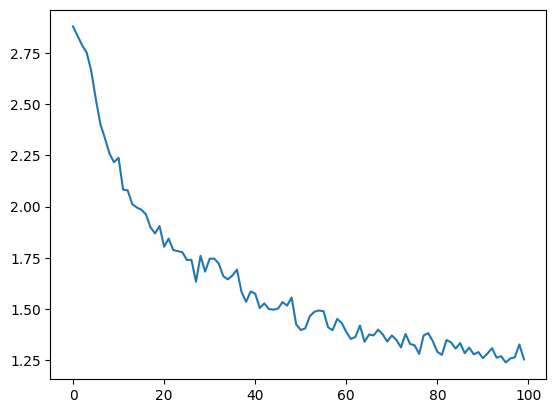

In [63]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_10692\509532827.py:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + all_categories, rotation=90)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_10692\509532827.py:36: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + all_categories)


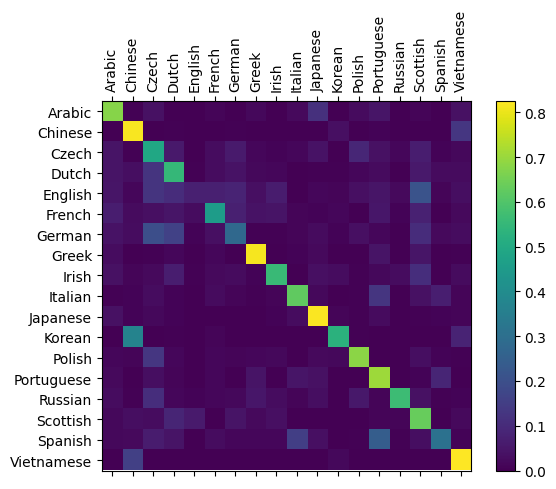

In [64]:
#Evaluate

# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output) # Logsoftmax는 monoTop-k를 썻기 때문에
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

In [88]:
# output은 log softmax되있는 상태이다. 확인해보기

category, line, category_tensor, line_tensor = randomTrainingExample()
output = evaluate(line_tensor)
torch.exp(output).sum()

tensor(1.0000, grad_fn=<SumBackward0>)

In [95]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            #value = topv[0][i].item()
            value = torch.exp(topv[0][i]).item() # 확률값으로 표시하기
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('Jang')
predict('Ahn')
predict('Smith')


> Jang
(0.62) Korean
(0.26) Chinese
(0.06) Vietnamese

> Ahn
(0.37) Korean
(0.25) Chinese
(0.20) Vietnamese

> Smith
(0.54) Scottish
(0.08) German
(0.08) Japanese


# 2.